# Interpretability, Stability and Algorithmic Fairness Project


## Step 0. Import packages and load data

In [1]:
# ============================================================================
# IMPORTS - All necessary libraries for the entire project
# ============================================================================

# Data manipulation and analysis
import numpy as np 
import pandas as pd
from ydata_profiling import ProfileReport
from typing import Tuple, Sequence

# Machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier

# Utilities
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the loan dataset
df_n = pd.read_csv("/Users/tiantiandawang/Desktop/hec/interpretabilit/dataproject2025.csv")

In [3]:
# Check for missing values in the dataset
df_n.isna().sum()

Unnamed: 0                   0
issue_d                    447
loan duration              447
annual_inc                 447
avg_cur_bal                447
bc_open_to_buy             447
bc_util                    447
delinq_2yrs                447
dti                        447
emp_length                 447
emp_title                  447
fico_range_high            447
funded_amnt                447
grade                      447
home_ownership             447
inq_last_6mths             447
int_rate                   447
mo_sin_old_rev_tl_op       447
mo_sin_rcnt_rev_tl_op      447
mo_sin_rcnt_tl             447
mort_acc                   447
mths_since_recent_bc       447
num_actv_bc_tl             447
num_bc_tl                  447
num_il_tl                  447
num_rev_accts              447
open_acc                   447
pub_rec                    447
pub_rec_bankruptcies       447
purpose                    447
revol_bal                  447
revol_util                 447
sub_grad

In [4]:
# Remove rows with missing values for clean analysis
df = df_n.dropna()

In [5]:
df.head()

,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013.0,0.0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0.0,0.0,782.0,7.388592,0.0,0.053051
1,1,2013.0,0.0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0.0,0.0,481.0,9.745456,0.0,0.084507
2,2,2013.0,0.0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0.0,0.0,945.0,7.542862,0.0,0.037206
3,3,2013.0,0.0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0.0,0.0,809.0,6.598132,0.0,0.061371
4,4,2013.0,1.0,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1.0,0.0,802.0,7.058900,1.0,0.345896


In [6]:
# Check column names and data types
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print(f"\nDataframe shape: {df.shape}")

Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']

Data types:
Unnamed: 0                   int64
issue_d                    float64
loan duration              float64
annual_inc                 float64
avg_cur_bal                float64
bc_open_to_buy             float64
bc_util                    float64
delinq_2yrs                float64
dti                        float64
emp_length                  object
emp_title                  

In [7]:
# profile1 = ProfileReport(df, title="Pandas Profiling Report")

In [8]:
# profile1

In [9]:
for col in df.select_dtypes(include="object").columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 50)

Column: emp_length
['2 years' '10+ years' '5 years' '6 years' '4 years' '3 years' '9 years'
 '8 years' '1 year' '< 1 year' '7 years']
--------------------------------------------------
Column: emp_title
['other' 'sales manager' 'driver' 'operations manager' 'teacher'
 'associate' 'business analyst' 'manager' 'customer service'
 'administrative assistant' 'general manager' 'vice president'
 'supervisor' 'administrator' 'project manager' 'nurse' 'electrician'
 'account manager' 'sales' 'director' 'technician'
 'chief executive officer' 'engineer' 'mechanic' 'truck driver'
 'executive assistant' 'customer service representative'
 'software engineer' 'operator' 'office manager' 'analyst'
 'police officer' 'owner' 'consultant' 'store manager' 'accountant'
 'account executive' 'attorney' 'server' 'financial analyst' 'maintenance'
 'clerk' 'superintendent' 'president' 'program manager'
 'assistant manager' 'machine operator' 'controller' 'paralegal' 'foreman'
 'branch manager']
--------------

In [10]:
df['issue_d'].value_counts()

issue_d
2015.0    271416
2016.0    258793
2017.0    173474
2014.0    152117
2018.0     94893
2013.0     86574
2019.0     32368
2012.0     14324
2020.0      1830
Name: count, dtype: int64

## Step 1.

## Step 2. 

In [11]:
# Prepare feature matrix X and target vector y
# Remove unnecessary columns (index, target, and existing predictions)
X = df.drop(columns=['Unnamed: 0', 'target', 'Predictions', 'Predicted probabilities'])
y = df['target']

### Time-based Train/Validation/Test Split

Using time-based splitting to prevent data leakage and simulate real-world prediction scenarios.

In [12]:
def train_val_test_split_by_year(
    df: pd.DataFrame,
    year_col: str,
    train_end: int,
    val_end: int,
    feature_cols: Sequence[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.Series,
           pd.DataFrame, pd.Series,
           pd.DataFrame, pd.Series]:
    """
    Time-based split into train/val/test:
      train: year <= train_end
      val  : train_end < year <= val_end
      test : year > val_end
    Assumes df[year_col] is already integer years.
    """
    year = df[year_col].astype(int)

    train_mask = year <= train_end
    val_mask   = (year > train_end) & (year <= val_end)
    test_mask  = year > val_end

    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, target_col]

    X_val   = df.loc[val_mask, feature_cols]
    y_val   = df.loc[val_mask, target_col]

    X_test  = df.loc[test_mask, feature_cols]
    y_test  = df.loc[test_mask, target_col]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_by_year(
    df,
    year_col='issue_d',
    train_end=2016,   # train: <= 2016
    val_end=2017,     # val: = 2017
    feature_cols=X.columns.tolist(),
    target_col='target'
)

print(f"Train set: {X_train.shape}, Val set: {X_val.shape}, Test set: {X_test.shape}")
print("Class distribution train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Class distribution val  :", y_val.value_counts(normalize=True).round(3).to_dict())
print("Class distribution test :", y_test.value_counts(normalize=True).round(3).to_dict())

Train set: (783224, 35), Val set: (173474, 35), Test set: (129091, 35)
Class distribution train: {0.0: 0.797, 1.0: 0.203}
Class distribution val  : {0.0: 0.773, 1.0: 0.227}
Class distribution test : {0.0: 0.767, 1.0: 0.233}


### Feature Engineering Pipeline

Setting up preprocessing for different feature types: numerical, ordinal, and categorical.

In [13]:
# Define feature categories for preprocessing
ordinal_features = ["emp_length"]  # Features with natural ordering
onehot_features = ["home_ownership", "purpose", "emp_title"]  # Categorical features
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Continuous features

# Define custom ordering for employment length (ordinal encoding)
emp_length_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
                    "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]

# Create ordinal encoder with custom ordering
ord_encoder = OrdinalEncoder(
    categories=[emp_length_order],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Build preprocessing pipeline with different transformers for different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),  # Scale numerical features
        ("ord", ord_encoder, ordinal_features),  # Encode ordinal features
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_features),  # One-hot encode categorical
    ]
)

### Baseline Model Training

Training LightGBM models with default and balanced class weights for comparison.

In [14]:
# Train baseline LightGBM model (no class balancing)
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        # class_weight="balanced",  # Commented out for baseline
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
y_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

print("LightGBM - Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("LightGBM - AUC:", round(roc_auc_score(y_val, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

LightGBM - Accuracy: 0.7792
LightGBM - AUC: 0.711

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.98      0.87    134177
         1.0       0.57      0.10      0.17     39297

    accuracy                           0.78    173474
   macro avg       0.68      0.54      0.52    173474
weighted avg       0.74      0.78      0.71    173474



In [15]:
# Train LightGBM with balanced class weights to handle class imbalance
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        class_weight="balanced",  # Automatically balance class weights
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
y_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

print("LightGBM_balanced - Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("LightGBM_balanced - AUC:", round(roc_auc_score(y_val, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

LightGBM_balanced - Accuracy: 0.6393
LightGBM_balanced - AUC: 0.7113

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.63      0.73    134177
         1.0       0.35      0.68      0.46     39297

    accuracy                           0.64    173474
   macro avg       0.61      0.65      0.59    173474
weighted avg       0.75      0.64      0.67    173474



### Hyperparameter Optimization

The following cell contains commented Optuna code for hyperparameter tuning. The best parameters found are used in subsequent cells.

In [16]:
# # Optuna tuning for LightGBM (optimize ROC-AUC) with fixed validation set
# import optuna

# warnings.filterwarnings("ignore")

# # Positive class is 1 (charged-off)
# pos = int((y_train == 1).sum())
# neg = int((y_train == 0).sum())
# spw_base = max(neg / max(pos, 1), 1.0)

# def make_lgbm(trial):
#     return LGBMClassifier(
#         n_estimators      = trial.suggest_int("n_estimators", 300, 1500),
#         learning_rate     = trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
#         num_leaves        = trial.suggest_int("num_leaves", 31, 255),
#         max_depth         = trial.suggest_int("max_depth", -1, 12),
#         min_child_samples = trial.suggest_int("min_child_samples", 20, 200),
#         min_child_weight  = trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
#         subsample         = trial.suggest_float("subsample", 0.6, 1.0),
#         colsample_bytree  = trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         reg_alpha         = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         reg_lambda        = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),

#         scale_pos_weight  = spw_base,
#         n_jobs            = -1,
#         random_state      = 42,
#     )

# def objective(trial):
#     clf = make_lgbm(trial)
#     pipe = Pipeline([("preprocessor", preprocessor), ("clf", clf)])
#     pipe.fit(X_train, y_train)
#     proba = pipe.predict_proba(X_val)[:, 1]
#     ap  = average_precision_score(y_val, proba)
#     auc = roc_auc_score(y_val, proba)
#     # primary: AP; small tie-breaker with ROC
#     return float(ap + 1e-3 * auc)

# sampler = optuna.samplers.TPESampler(seed=42)
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)
# study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=40, gc_after_trial=True)

# print("Best value :", study.best_value)
# print("Best params:", study.best_trial.params)


In [17]:
"""
[I 2025-09-25 14:31:01,743] A new study created in memory with name: no-name-a73ef694-a0e6-4ca9-9626-a8e302a9e9d8
[I 2025-09-25 14:31:15,838] Trial 0 finished with value: 0.4124885635244692 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682}. Best is trial 0 with value: 0.4124885635244692.
[I 2025-09-25 14:31:21,684] Trial 1 finished with value: 0.40355827811404454 and parameters: {'n_estimators': 324, 'learning_rate': 0.18661212048851336, 'num_leaves': 218, 'max_depth': 1, 'min_child_samples': 52, 'min_child_weight': 0.00541524411940254, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06}. Best is trial 0 with value: 0.4124885635244692.
[I 2025-09-25 14:31:44,865] Trial 2 finished with value: 0.4188036311261316 and parameters: {'n_estimators': 1034, 'learning_rate': 0.027575529238707534, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 102, 'min_child_weight': 1.382623217936987, 'subsample': 0.6798695128633439, 'colsample_bytree': 0.8056937753654446, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 2 with value: 0.4188036311261316.
[I 2025-09-25 14:32:38,202] Trial 3 finished with value: 0.42350184158517185 and parameters: {'n_estimators': 1029, 'learning_rate': 0.029617890239950373, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 194, 'min_child_weight': 1.7123375973163988, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_alpha': 0.014391207615728067, 'reg_lambda': 9.148975058772307e-05}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:33:00,175] Trial 4 finished with value: 0.4218262576178775 and parameters: {'n_estimators': 446, 'learning_rate': 0.06254706073560744, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 66, 'min_child_weight': 0.4467752817973907, 'subsample': 0.7246844304357644, 'colsample_bytree': 0.8080272084711243, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:35:47,283] Trial 5 finished with value: 0.4035570553299044 and parameters: {'n_estimators': 1464, 'learning_rate': 0.11916886939345038, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 128, 'min_child_weight': 4.869640941520899, 'subsample': 0.6353970008207678, 'colsample_bytree': 0.6783931449676581, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:36:14,349] Trial 6 finished with value: 0.41429467074713594 and parameters: {'n_estimators': 766, 'learning_rate': 0.03735760514214135, 'num_leaves': 217, 'max_depth': 3, 'min_child_samples': 70, 'min_child_weight': 0.14817820606039092, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'reg_alpha': 4.6876566400928895e-08, 'reg_lambda': 7.620481786158549}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:37:20,413] Trial 7 finished with value: 0.42343067840579596 and parameters: {'n_estimators': 1227, 'learning_rate': 0.031604263728207765, 'num_leaves': 32, 'max_depth': 10, 'min_child_samples': 147, 'min_child_weight': 0.8241925264876453, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:38:37,439] Trial 8 finished with value: 0.418566322579012 and parameters: {'n_estimators': 1336, 'learning_rate': 0.084009446334044, 'num_leaves': 105, 'max_depth': -1, 'min_child_samples': 76, 'min_child_weight': 0.01998634077852888, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:38:48,874] Trial 9 finished with value: 0.42515698690294507 and parameters: {'n_estimators': 443, 'learning_rate': 0.10334150520046555, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 159, 'min_child_weight': 0.09444574254983566, 'subsample': 0.8090931317527976, 'colsample_bytree': 0.7710164073434198, 'reg_alpha': 1.6934490731313353e-08, 'reg_lambda': 9.354548757337708e-08}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:03,224] Trial 10 finished with value: 0.425116219535296 and parameters: {'n_estimators': 549, 'learning_rate': 0.059478131551414695, 'num_leaves': 168, 'max_depth': 7, 'min_child_samples': 180, 'min_child_weight': 0.03717702150126786, 'subsample': 0.8208781805340754, 'colsample_bytree': 0.7156237038334943, 'reg_alpha': 8.46106948686665e-07, 'reg_lambda': 0.010367714070333529}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:17,790] Trial 11 finished with value: 0.4245596698774353 and parameters: {'n_estimators': 521, 'learning_rate': 0.05507813170238614, 'num_leaves': 165, 'max_depth': 7, 'min_child_samples': 181, 'min_child_weight': 0.03740962387403666, 'subsample': 0.8224761781765364, 'colsample_bytree': 0.7178822054585058, 'reg_alpha': 8.76040867180857e-07, 'reg_lambda': 0.02419584192691601}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:48,665] Trial 12 finished with value: 0.42322609920655313 and parameters: {'n_estimators': 609, 'learning_rate': 0.09785129931240315, 'num_leaves': 153, 'max_depth': 8, 'min_child_samples': 159, 'min_child_weight': 0.10044782868101039, 'subsample': 0.8221524940198316, 'colsample_bytree': 0.7371197153065265, 'reg_alpha': 1.283750567305851e-06, 'reg_lambda': 0.010120698664942676}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:40:12,002] Trial 13 finished with value: 0.41855995558945264 and parameters: {'n_estimators': 304, 'learning_rate': 0.04587270929523388, 'num_leaves': 181, 'max_depth': 6, 'min_child_samples': 166, 'min_child_weight': 0.020334906684860966, 'subsample': 0.9724891986137659, 'colsample_bytree': 0.7389455428332762, 'reg_alpha': 5.960361308700738e-07, 'reg_lambda': 0.8251356297038612}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:40:36,772] Trial 14 finished with value: 0.42338419098905056 and parameters: {'n_estimators': 701, 'learning_rate': 0.0841644837632613, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 128, 'min_child_weight': 0.001879254833690615, 'subsample': 0.8647080858469188, 'colsample_bytree': 0.6954213319864813, 'reg_alpha': 1.2557486015764376e-08, 'reg_lambda': 0.0025363951381964945}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:41:11,412] Trial 15 finished with value: 0.40885910798908487 and parameters: {'n_estimators': 480, 'learning_rate': 0.13855097720691706, 'num_leaves': 255, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.17352840584427187, 'subsample': 0.7807775475387444, 'colsample_bytree': 0.869308716305864, 'reg_alpha': 8.950924485478923e-06, 'reg_lambda': 0.17988154860497957}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:41:53,717] Trial 16 finished with value: 0.41926484887354076 and parameters: {'n_estimators': 925, 'learning_rate': 0.021293596590604497, 'num_leaves': 196, 'max_depth': 5, 'min_child_samples': 197, 'min_child_weight': 0.04556263914101204, 'subsample': 0.7752036656043477, 'colsample_bytree': 0.758229806954334, 'reg_alpha': 1.7846159484277026e-07, 'reg_lambda': 1.6222441544563988e-05}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:42:11,603] Trial 17 finished with value: 0.4118289416622911 and parameters: {'n_estimators': 608, 'learning_rate': 0.0740544898164958, 'num_leaves': 126, 'max_depth': 2, 'min_child_samples': 142, 'min_child_weight': 0.009759295710164394, 'subsample': 0.9397411492889054, 'colsample_bytree': 0.6681845114128452, 'reg_alpha': 8.019073278911363e-06, 'reg_lambda': 0.0010378973903210163}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:42:35,804] Trial 18 finished with value: 0.42157449741212843 and parameters: {'n_estimators': 424, 'learning_rate': 0.04829959080147578, 'num_leaves': 170, 'max_depth': 6, 'min_child_samples': 175, 'min_child_weight': 0.29612980435114955, 'subsample': 0.8607769576771078, 'colsample_bytree': 0.7757701652042633, 'reg_alpha': 5.0363789132431, 'reg_lambda': 2.455918006464903e-08}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:43:28,486] Trial 19 finished with value: 0.4165545878858035 and parameters: {'n_estimators': 867, 'learning_rate': 0.11726235890480016, 'num_leaves': 220, 'max_depth': 8, 'min_child_samples': 108, 'min_child_weight': 0.04325180977713664, 'subsample': 0.7757526351833268, 'colsample_bytree': 0.9925252347033172, 'reg_alpha': 1.3941020893526537e-07, 'reg_lambda': 5.691318929182572e-07}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:44:10,503] Trial 20 finished with value: 0.42662436252483843 and parameters: {'n_estimators': 595, 'learning_rate': 0.06990305155464922, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 153, 'min_child_weight': 0.001230049810567648, 'subsample': 0.8290486446477119, 'colsample_bytree': 0.6085543667444748, 'reg_alpha': 0.041020624131075656, 'reg_lambda': 0.3458102879777702}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:45:00,404] Trial 21 finished with value: 0.42523874563720027 and parameters: {'n_estimators': 599, 'learning_rate': 0.06834142840894819, 'num_leaves': 140, 'max_depth': 9, 'min_child_samples': 146, 'min_child_weight': 0.0011158620966087484, 'subsample': 0.8393544337390497, 'colsample_bytree': 0.6114948874411064, 'reg_alpha': 0.05294054339532663, 'reg_lambda': 0.34285796837860133}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:45:51,135] Trial 22 finished with value: 0.42460311640464815 and parameters: {'n_estimators': 661, 'learning_rate': 0.07811642157174385, 'num_leaves': 136, 'max_depth': 9, 'min_child_samples': 147, 'min_child_weight': 0.0012454733585249747, 'subsample': 0.8520987322399567, 'colsample_bytree': 0.6021625329242458, 'reg_alpha': 0.07415111704352027, 'reg_lambda': 8.296641909219783}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:46:15,163] Trial 23 finished with value: 0.4234969830092411 and parameters: {'n_estimators': 388, 'learning_rate': 0.1040550254710474, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 130, 'min_child_weight': 0.0022552629979310755, 'subsample': 0.7485202093651705, 'colsample_bytree': 0.61109800293869, 'reg_alpha': 0.1577631783193009, 'reg_lambda': 0.4438475286373584}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:47:01,669] Trial 24 finished with value: 0.41530394278724314 and parameters: {'n_estimators': 801, 'learning_rate': 0.1472842743065627, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 158, 'min_child_weight': 0.001002417059933003, 'subsample': 0.8997072981824707, 'colsample_bytree': 0.649696188386054, 'reg_alpha': 0.02725912411723744, 'reg_lambda': 0.1205912196762187}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:47:49,224] Trial 25 finished with value: 0.42367890658860113 and parameters: {'n_estimators': 541, 'learning_rate': 0.06901447649282681, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 98, 'min_child_weight': 0.005903759212668298, 'subsample': 0.8022304054975694, 'colsample_bytree': 0.6002684078306731, 'reg_alpha': 0.3407068582238012, 'reg_lambda': 2.9959665602009067}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:01,891] Trial 26 finished with value: 0.4247375108270009 and parameters: {'n_estimators': 658, 'learning_rate': 0.09933348774611177, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 119, 'min_child_weight': 6.111781182391502, 'subsample': 0.9367531787495578, 'colsample_bytree': 0.6565206563909913, 'reg_alpha': 0.0001340165181838073, 'reg_lambda': 0.0864774300427382}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:14,870] Trial 27 finished with value: 0.42236927760059506 and parameters: {'n_estimators': 391, 'learning_rate': 0.04365097024942366, 'num_leaves': 76, 'max_depth': 8, 'min_child_samples': 142, 'min_child_weight': 0.010420352810072513, 'subsample': 0.8510992495340646, 'colsample_bytree': 0.8517156611049723, 'reg_alpha': 0.01063205588978806, 'reg_lambda': 1.4681671774018707}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:49,203] Trial 28 finished with value: 0.4251133501664635 and parameters: {'n_estimators': 962, 'learning_rate': 0.05254161945222833, 'num_leaves': 191, 'max_depth': 10, 'min_child_samples': 165, 'min_child_weight': 0.002361728562015331, 'subsample': 0.7590087532174032, 'colsample_bytree': 0.6315173012723327, 'reg_alpha': 4.245827031110886, 'reg_lambda': 0.001447551090021519}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:09,412] Trial 29 finished with value: 0.4211619344049207 and parameters: {'n_estimators': 793, 'learning_rate': 0.13502987900006488, 'num_leaves': 155, 'max_depth': 7, 'min_child_samples': 93, 'min_child_weight': 0.004012587515523726, 'subsample': 0.8132890804996505, 'colsample_bytree': 0.8914058771564304, 'reg_alpha': 0.004031021171445679, 'reg_lambda': 4.053140892519326e-05}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:24,588] Trial 30 finished with value: 0.42538270681941004 and parameters: {'n_estimators': 574, 'learning_rate': 0.06576812450624586, 'num_leaves': 194, 'max_depth': 6, 'min_child_samples': 151, 'min_child_weight': 0.011243822656371093, 'subsample': 0.9992790868195935, 'colsample_bytree': 0.696223209699688, 'reg_alpha': 1.5322413985956158, 'reg_lambda': 0.030220602303410005}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:39,985] Trial 31 finished with value: 0.42491084693880643 and parameters: {'n_estimators': 601, 'learning_rate': 0.06694158178165424, 'num_leaves': 204, 'max_depth': 6, 'min_child_samples': 149, 'min_child_weight': 0.003597803009402215, 'subsample': 0.9946314631574408, 'colsample_bytree': 0.6902196181667268, 'reg_alpha': 0.48063528942262523, 'reg_lambda': 0.036706525774526856}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:50,516] Trial 32 finished with value: 0.42187244635322935 and parameters: {'n_estimators': 501, 'learning_rate': 0.09080274311388876, 'num_leaves': 180, 'max_depth': 4, 'min_child_samples': 135, 'min_child_weight': 0.008526913819004629, 'subsample': 0.9297776667486733, 'colsample_bytree': 0.7860728039506719, 'reg_alpha': 1.282520572719311, 'reg_lambda': 0.006431859508423387}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:08,665] Trial 33 finished with value: 0.4193102228720284 and parameters: {'n_estimators': 704, 'learning_rate': 0.16551726019792706, 'num_leaves': 227, 'max_depth': 7, 'min_child_samples': 115, 'min_child_weight': 0.016852146254386236, 'subsample': 0.8772743671150867, 'colsample_bytree': 0.7092500240584194, 'reg_alpha': 0.11727145053702989, 'reg_lambda': 0.34254931983605197}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:21,452] Trial 34 finished with value: 0.42347736005826336 and parameters: {'n_estimators': 379, 'learning_rate': 0.11207764030589104, 'num_leaves': 148, 'max_depth': 8, 'min_child_samples': 173, 'min_child_weight': 0.0015043471209191558, 'subsample': 0.705375790107123, 'colsample_bytree': 0.6275160433535212, 'reg_alpha': 0.0008013740839938215, 'reg_lambda': 0.06940918207999015}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:39,487] Trial 35 finished with value: 0.4247262543747706 and parameters: {'n_estimators': 847, 'learning_rate': 0.06352129491753777, 'num_leaves': 206, 'max_depth': 5, 'min_child_samples': 158, 'min_child_weight': 0.0038354531178649877, 'subsample': 0.9625753638453611, 'colsample_bytree': 0.8278852893138211, 'reg_alpha': 0.02857362121439979, 'reg_lambda': 1.2823360125443925e-06}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:51:07,576] Trial 36 finished with value: 0.4254734092508453 and parameters: {'n_estimators': 581, 'learning_rate': 0.038059863529300964, 'num_leaves': 234, 'max_depth': 11, 'min_child_samples': 189, 'min_child_weight': 0.06881555820473159, 'subsample': 0.8355560148961885, 'colsample_bytree': 0.6576000753273963, 'reg_alpha': 8.598905330263047, 'reg_lambda': 2.3134908831448877}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:51:51,877] Trial 37 finished with value: 0.42622872217902374 and parameters: {'n_estimators': 1124, 'learning_rate': 0.03533431143718544, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 190, 'min_child_weight': 0.0073733907178161, 'subsample': 0.6005800047171014, 'colsample_bytree': 0.6578064097386143, 'reg_alpha': 8.739149111172196, 'reg_lambda': 2.0816280388884763}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:52:50,744] Trial 38 finished with value: 0.42541686415841484 and parameters: {'n_estimators': 1155, 'learning_rate': 0.03883058166366402, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 189, 'min_child_weight': 0.014659686980769296, 'subsample': 0.6059202522570125, 'colsample_bytree': 0.6704329580663375, 'reg_alpha': 7.474320138942919, 'reg_lambda': 3.933485858540299}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:53:35,133] Trial 39 finished with value: 0.4259008858356334 and parameters: {'n_estimators': 1141, 'learning_rate': 0.036563308541059804, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 192, 'min_child_weight': 0.0689854683932055, 'subsample': 0.6033868008251051, 'colsample_bytree': 0.6687789389494984, 'reg_alpha': 9.461124388774783, 'reg_lambda': 2.4011583881482133}. Best is trial 20 with value: 0.42662436252483843.
Best value: 0.42662436252483843
Best params: {'n_estimators': 595, 'learning_rate': 0.06990305155464922, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 153, 'min_child_weight': 0.001230049810567648, 'subsample': 0.8290486446477119, 'colsample_bytree': 0.6085543667444748, 'reg_alpha': 0.041020624131075656, 'reg_lambda': 0.3458102879777702}
"""

"\n[I 2025-09-25 14:31:01,743] A new study created in memory with name: no-name-a73ef694-a0e6-4ca9-9626-a8e302a9e9d8\n[I 2025-09-25 14:31:15,838] Trial 0 finished with value: 0.4124885635244692 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682}. Best is trial 0 with value: 0.4124885635244692.\n[I 2025-09-25 14:31:21,684] Trial 1 finished with value: 0.40355827811404454 and parameters: {'n_estimators': 324, 'learning_rate': 0.18661212048851336, 'num_leaves': 218, 'max_depth': 1, 'min_child_samples': 52, 'min_child_weight': 0.00541524411940254, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06}. Best is trial 0 with value: 0.412488

### Final Model Training with Best Parameters

Training the final model with optimized hyperparameters found through Optuna tuning.

In [18]:
# Calculate class imbalance ratio for scale_pos_weight parameter
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw_base = max(neg / max(pos, 1), 1.0)

# Create final model with best hyperparameters from Optuna optimization
best_clf = LGBMClassifier(
    n_estimators=595,
    learning_rate=0.06990305155464922,
    num_leaves=141,
    max_depth=9,
    min_child_samples=153,
    min_child_weight=0.001230049810567648,
    subsample=0.8290486446477119,
    colsample_bytree=0.6085543667444748,
    reg_alpha=0.041020624131075656,
    reg_lambda=0.3458102879777702,
    scale_pos_weight=spw_base,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
)

# Build final pipeline and train on training set
final_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_clf)])
final_pipe.fit(X_train, y_train)

# Evaluate on validation set
y_proba = final_pipe.predict_proba(X_val)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))
print("PR-AUC :", average_precision_score(y_val, y_proba))
print("\nClassification Report:\n", classification_report(
    y_val, y_pred, target_names=["fully_paid(0)","charged_off(1)"], zero_division=0
))

Accuracy: 0.6608137242468612
ROC-AUC: 0.716903166539775
PR-AUC : 0.4254334963407185

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.87      0.66      0.75    134177
charged_off(1)       0.36      0.65      0.46     39297

      accuracy                           0.66    173474
     macro avg       0.61      0.66      0.61    173474
  weighted avg       0.75      0.66      0.69    173474



In [19]:
# Combine training and validation sets for final model training
X_trval = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_trval = pd.concat([y_train, y_val], axis=0, ignore_index=True)

## Step3

In [20]:
# Train final model on combined train+validation data and evaluate on test set
final_pipe.fit(X_trval, y_trval)

y_proba = final_pipe.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

# Final test set performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(
    y_test, y_pred, target_names=["fully_paid(0)","charged_off(1)"], zero_division=0
))

Accuracy: 0.638588282684308
ROC-AUC: 0.72392667146322
PR-AUC : 0.4416700234537933

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.87      0.62      0.72     99057
charged_off(1)       0.36      0.71      0.48     30034

      accuracy                           0.64    129091
     macro avg       0.62      0.66      0.60    129091
  weighted avg       0.75      0.64      0.67    129091



In [21]:
# Get feature names after preprocessing transformations
feature_names = preprocessor.get_feature_names_out()

# Create DataFrame with transformed features for interpretability analysis
X_to_explain = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

In [22]:
X_to_explain.head()

,num__issue_d,num__loan duration,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__fico_range_high,num__funded_amnt,...,onehot__emp_title_sales manager,onehot__emp_title_server,onehot__emp_title_software engineer,onehot__emp_title_store manager,onehot__emp_title_superintendent,onehot__emp_title_supervisor,onehot__emp_title_teacher,onehot__emp_title_technician,onehot__emp_title_truck driver,onehot__emp_title_vice president
174250,2.182343,-0.636834,0.832841,0.849624,-0.188342,0.004263,0.705472,-0.517541,-1.109074,-0.187733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174251,2.182343,-0.636834,-0.734327,-0.157506,-0.303046,-0.454726,-0.377803,0.211415,0.118118,-0.951180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174252,2.182343,1.570269,0.067066,-0.305891,0.507512,-0.877287,0.705472,-0.322519,-0.933761,0.554207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174253,2.182343,-0.636834,0.387623,-0.439106,3.444467,-1.310777,-0.377803,1.461223,0.994685,1.306901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174254,2.182343,-0.636834,-0.948031,-0.826582,-0.169271,-2.236040,-0.377803,-2.069396,3.273757,-1.004944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## More

## Step 4.

>>> Preparing features for surrogate tree...
>>> [Surrogate no-OHE] Feature matrix shapes: train=(783224, 32), test=(129091, 32)
>>> Training surrogate Decision Tree (regression to LGBM proba)...
>>> Surrogate tree fit complete.

================ SURROGATE =================
Fidelity Corr (probs vs LGBM): 0.8637
Fidelity MSE  (probs vs LGBM): 0.012905
Surrogate AUC (vs y_test):     0.6831

Top features driving surrogate tree:
              feature  importance
             int_rate    0.790796
        loan duration    0.057603
          avg_cur_bal    0.050993
                  dti    0.024437
      fico_range_high    0.017794
 mths_since_recent_bc    0.016255
          funded_amnt    0.010573
             mort_acc    0.008684
 mo_sin_old_rev_tl_op    0.005448
   home_ownership__te    0.004365
       mo_sin_rcnt_tl    0.003569
            revol_bal    0.003447
             zip_code    0.002137
           annual_inc    0.001171
        emp_title__te    0.001046
mo_sin_rcnt_rev_tl_op    0.

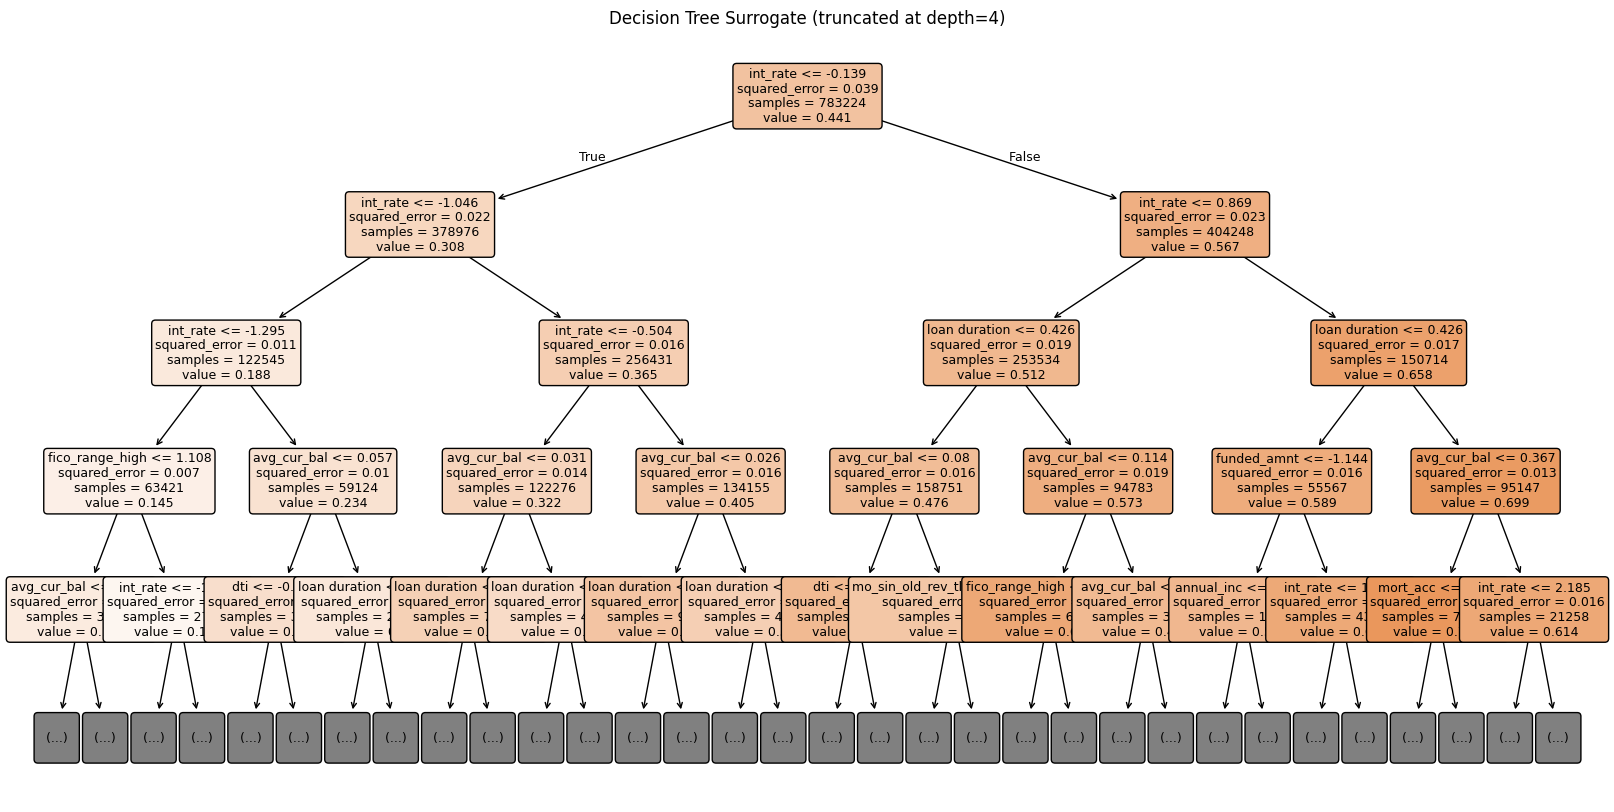


Example rules (depth<=4):
|--- int_rate <= -0.14
|   |--- int_rate <= -1.05
|   |   |--- int_rate <= -1.30
|   |   |   |--- fico_range_high <= 1.11
|   |   |   |   |--- avg_cur_bal <= 0.20
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- avg_cur_bal >  0.20
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- fico_range_high >  1.11
|   |   |   |   |--- int_rate <= -1.59
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- int_rate >  -1.59
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |--- int_rate >  -1.30
|   |   |   |--- avg_cur_bal <= 0.06
|   |   |   |   |--- dti <= -0.19
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- dti >  -0.19
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- avg_cur_bal >  0.06
|   |   |   |   |--- loan duration <= 0.43
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- loan duration >  0.43
|   |   |   |   |   

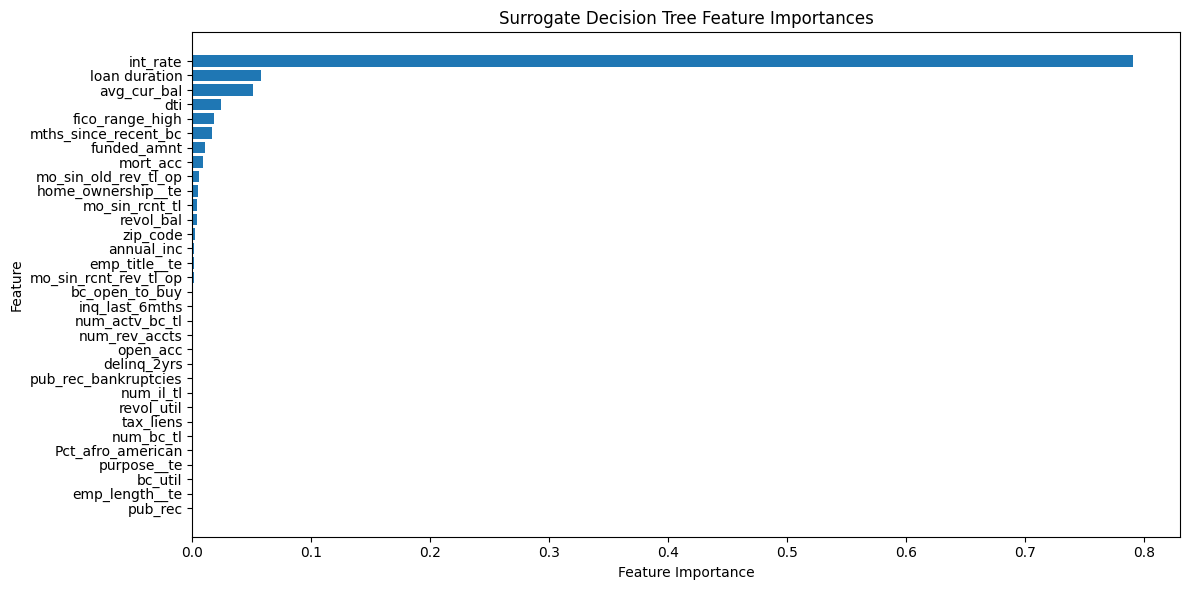

In [26]:
## Step 4.  — Surrogate Decision Tree (aligned with previous code)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_squared_error, roc_auc_score

print(">>> Preparing features for surrogate tree...")

# 0) Columns that must NEVER be used as features (time/leakage cols)
leakage_cols = {"issue_d"}

# 1) Get LGBM probabilities on train/test to mimic
p_train = final_pipe.predict_proba(X_train)[:, 1]
p_test  = final_pipe.predict_proba(X_test)[:, 1]

# 2) Define feature groups consistent with earlier code
#    - numerical_features already defined earlier from X (non-objects)
#    - use BOTH your onehot_features and ordinal_features as categorical here,
#      because we will target-encode them for the surrogate (no OHE).
categorical_features = list({*onehot_features, *ordinal_features})

# Keep only columns present in the split frames (safety) and EXCLUDE leakage cols like issue_d
categorical_features = [c for c in categorical_features if c in X_train.columns and c not in leakage_cols]
numerical_features   = [c for c in numerical_features   if c in X_train.columns   and c not in leakage_cols]

# 3) Smoothed target encoding helper (fit on TRAIN only)
def target_encode_series(train_s, test_s, target, m=1000):
    """
    Smoothed target encoding using the surrogate target "p_train":
      enc = (count*cat_mean + m*global_mean) / (count + m)
    """
    df = pd.DataFrame({"cat": train_s, "t": target})
    global_mean = df["t"].mean()
    stats = df.groupby("cat")["t"].agg(["mean", "count"])
    smooth = (stats["count"] * stats["mean"] + m * global_mean) / (stats["count"] + m)
    train_enc = train_s.map(smooth).fillna(global_mean)
    test_enc  = test_s.map(smooth).fillna(global_mean)
    return train_enc.values.reshape(-1, 1), test_enc.values.reshape(-1, 1)

# 4) Scale numeric; target-encode categoricals
scaler = StandardScaler()
Xn_train = scaler.fit_transform(X_train[numerical_features]) if numerical_features else np.empty((len(X_train), 0))
Xn_test  = scaler.transform(X_test[numerical_features])      if numerical_features else np.empty((len(X_test), 0))

Xe_train_list, Xe_test_list, enc_names = [], [], []
for col in categorical_features:
    tr_col, te_col = target_encode_series(X_train[col], X_test[col], p_train, m=1000)
    Xe_train_list.append(tr_col)
    Xe_test_list.append(te_col)
    enc_names.append(f"{col}__te")

if Xe_train_list:
    Xc_train = np.hstack(Xe_train_list)
    Xc_test  = np.hstack(Xe_test_list)
    X_sur_train = np.hstack([Xn_train, Xc_train]) if Xn_train.size else Xc_train
    X_sur_test  = np.hstack([Xn_test,  Xc_test])  if Xn_test.size  else Xc_test
    feature_names_sur = (numerical_features if numerical_features else []) + enc_names
else:
    X_sur_train = Xn_train
    X_sur_test  = Xn_test
    feature_names_sur = numerical_features[:]

print(f">>> [Surrogate no-OHE] Feature matrix shapes: train={X_sur_train.shape}, test={X_sur_test.shape}")

# 5) Fit the surrogate tree to mimic LGBM probabilities
print(">>> Training surrogate Decision Tree (regression to LGBM proba)...")
tree_surrogate = DecisionTreeRegressor(
    max_depth=9,
    min_samples_leaf=500,
    random_state=42
)
tree_surrogate.fit(X_sur_train, p_train)
print(">>> Surrogate tree fit complete.")

# 6) Evaluate fidelity and basic discrimination
p_hat_test = tree_surrogate.predict(X_sur_test)

fidelity_corr = np.corrcoef(p_test, p_hat_test)[0, 1]
fidelity_mse  = mean_squared_error(p_test, p_hat_test)
surrogate_auc = roc_auc_score(y_test, p_hat_test)

print("\n================ SURROGATE =================")
print(f"Fidelity Corr (probs vs LGBM): {fidelity_corr:.4f}")
print(f"Fidelity MSE  (probs vs LGBM): {fidelity_mse:.6f}")
print(f"Surrogate AUC (vs y_test):     {surrogate_auc:.4f}")
print("===========================================\n")

# 7) Feature importances
importances = pd.DataFrame({
    "feature": feature_names_sur,
    "importance": tree_surrogate.feature_importances_
}).sort_values("importance", ascending=False)

print("Top features driving surrogate tree:")
print(importances.head(20).to_string(index=False))

# 8) Visuals: tree (truncated) and importances
plt.figure(figsize=(20, 10))
plot_tree(
    tree_surrogate,
    feature_names=feature_names_sur,
    filled=True, rounded=True, fontsize=9, max_depth=4
)
plt.title("Decision Tree Surrogate (truncated at depth=4)")
plt.show()

try:
    print("\nExample rules (depth<=4):")
    print(export_text(tree_surrogate, feature_names=feature_names_sur, max_depth=4))
except Exception as e:
    print(f"[Tree] Skipped rule text: {e}")

plt.figure(figsize=(12, 6))
plt.barh(importances["feature"], importances["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Surrogate Decision Tree Feature Importances")
plt.tight_layout()
plt.show()


>>> [Logistic] Preparing data...
>>> [Logistic] Feature matrix shapes: train=(783224, 32), test=(129091, 32)
>>> [Logistic] Fitting Binomial GLM (penalized) on 783224 rows, 33 features...
>>> [Logistic] GLM fit complete.

================ SURROGATE (Penalized Logistic vs LGBM) ===============
Fidelity R^2 (log-odds vs LGBM): 0.7545
Fidelity Corr (probs  vs LGBM): 0.8822
MSE (probs vs LGBM):           0.011006
Surrogate AUC (vs y_test):     0.6907
Top 20 logistic-surrogate effects (log-odds per 1-SD / target-encoded level):
             feature      coef
       emp_title__te  1.741524
           Intercept -1.605073
  home_ownership__te  1.357051
      emp_length__te -0.569470
         purpose__te  0.497587
            int_rate  0.407193
       loan duration  0.247666
                 dti  0.161843
     fico_range_high -0.161810
         funded_amnt  0.115660
            mort_acc -0.096215
mths_since_recent_bc -0.085278
      mo_sin_rcnt_tl -0.076708
      bc_open_to_buy -0.076085
      

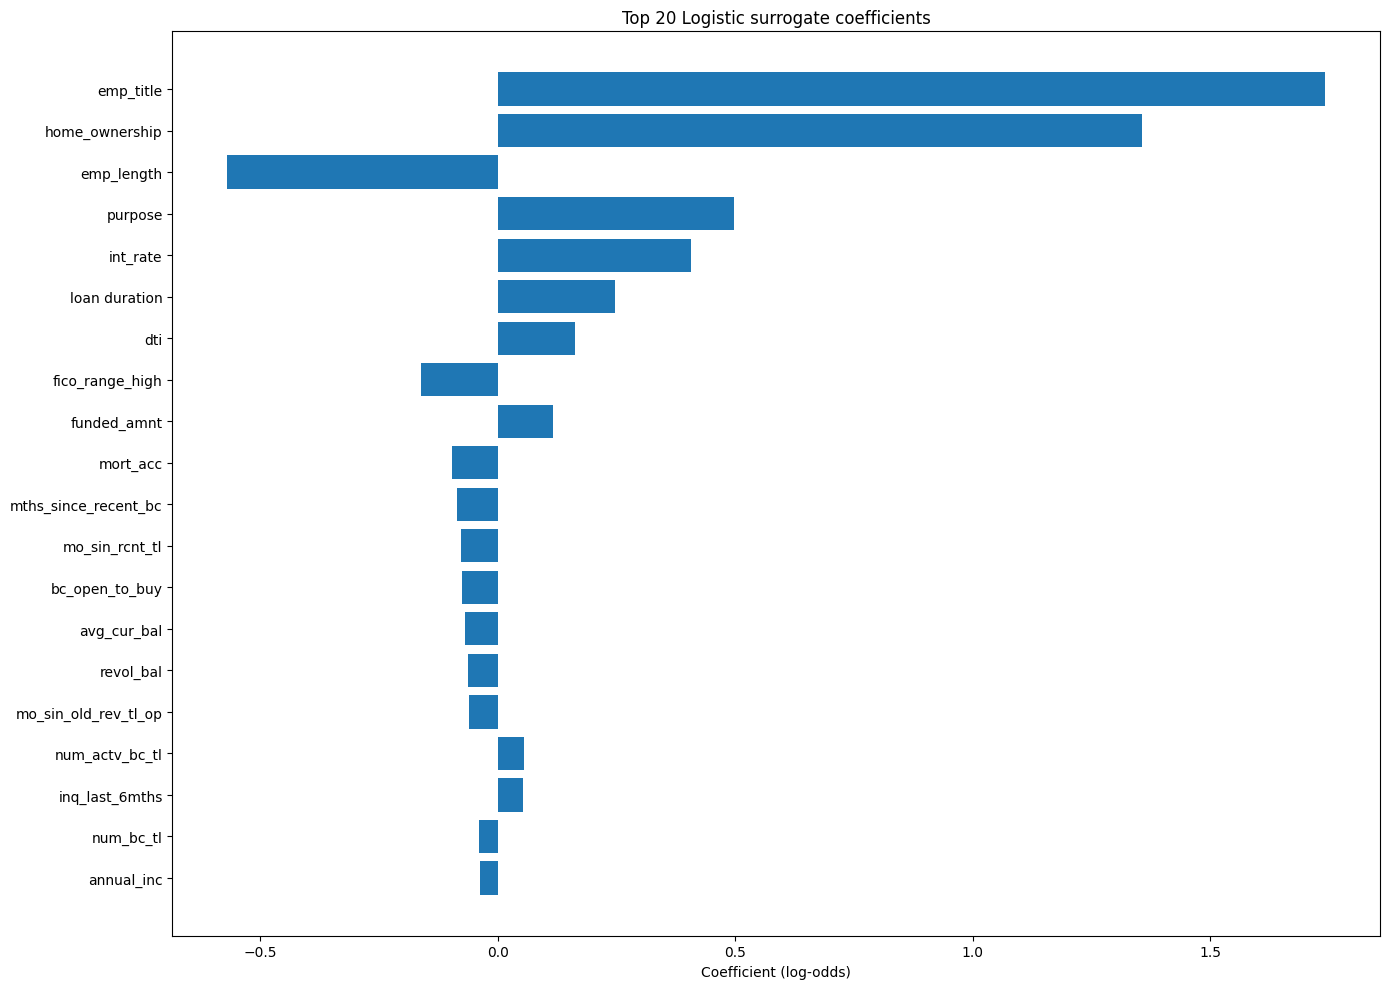

In [27]:
## Step 4b — Surrogate Penalized Logistic (mimic LGBM)

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
import matplotlib.pyplot as plt

print(">>> [Logistic] Preparing data...")

# 0) Columns that must NEVER be used as features (time/leakage cols)
leakage_cols = {"issue_d"}

# 1) Probabilities from the final LGBM on train/test (the thing we mimic)
p_train = final_pipe.predict_proba(X_train)[:, 1]
p_test  = final_pipe.predict_proba(X_test)[:, 1]

# Log-odds of the teacher model (used only for fidelity R^2 on logit scale)
eps = 1e-9
logit_train = np.log((p_train + eps) / (1 - p_train + eps))
logit_test  = np.log((p_test  + eps) / (1 - p_test  + eps))

# 2) Feature groups consistent with earlier code
#    Treat ordinal + categorical as categorical here and target-encode them.
categorical_cols = list({*onehot_features, *ordinal_features})
categorical_cols = [c for c in categorical_cols if c in X_train.columns and c not in leakage_cols]

numeric_cols = [c for c in numerical_features if c in X_train.columns and c not in leakage_cols]

# 3) Smoothed target encoding (fit on TRAIN using p_train as the target)
def target_encode_series(train_s, test_s, target, m=1000):
    """
    Smoothed target encoding against teacher proba:
      enc = (count*cat_mean + m*global_mean) / (count + m)
    """
    df = pd.DataFrame({"cat": train_s, "t": target})
    global_mean = df["t"].mean()
    stats = df.groupby("cat")["t"].agg(["mean", "count"])
    smooth = (stats["count"] * stats["mean"] + m * global_mean) / (stats["count"] + m)
    train_enc = train_s.map(smooth).fillna(global_mean)
    test_enc  = test_s.map(smooth).fillna(global_mean)
    return train_enc.values.reshape(-1, 1), test_enc.values.reshape(-1, 1)

# 4) Build surrogate design matrix: scale numerics, target-encode categoricals
scaler = StandardScaler()
Xn_train = scaler.fit_transform(X_train[numeric_cols]) if numeric_cols else np.empty((len(X_train), 0))
Xn_test  = scaler.transform(X_test[numeric_cols])      if numeric_cols else np.empty((len(X_test), 0))

Xe_train_list, Xe_test_list, enc_names = [], [], []
for col in categorical_cols:
    tr_col, te_col = target_encode_series(X_train[col], X_test[col], p_train, m=1000)
    Xe_train_list.append(tr_col)
    Xe_test_list.append(te_col)
    enc_names.append(f"{col}__te")

if Xe_train_list:
    Xc_train = np.hstack(Xe_train_list)
    Xc_test  = np.hstack(Xe_test_list)
    X_sur_train = np.hstack([Xn_train, Xc_train]) if Xn_train.size else Xc_train
    X_sur_test  = np.hstack([Xn_test,  Xc_test])  if Xn_test.size  else Xc_test
    feature_names_sur = (numeric_cols if numeric_cols else []) + enc_names
else:
    X_sur_train = Xn_train
    X_sur_test  = Xn_test
    feature_names_sur = numeric_cols[:]

print(f">>> [Logistic] Feature matrix shapes: train={X_sur_train.shape}, test={X_sur_test.shape}")

# 5) Add intercept and fit penalized Binomial GLM to mimic p_train
X_train_sm = sm.add_constant(X_sur_train, has_constant="add")
X_test_sm  = sm.add_constant(X_sur_test,  has_constant="add")

print(f">>> [Logistic] Fitting Binomial GLM (penalized) on {X_train_sm.shape[0]} rows, {X_train_sm.shape[1]} features...")
glm = sm.GLM(p_train, X_train_sm, family=sm.families.Binomial())
glm_results = glm.fit_regularized(alpha=1e-4, L1_wt=0.0, maxiter=200)
print(">>> [Logistic] GLM fit complete.")

# 6) Predictions, fidelity, discrimination
logit_hat_test = X_test_sm @ glm_results.params
logit_hat_test = np.clip(logit_hat_test, -30, 30)
p_hat_test = 1.0 / (1.0 + np.exp(-logit_hat_test))

fid_r2   = r2_score(logit_test, logit_hat_test)
fid_corr = np.corrcoef(p_test, p_hat_test)[0, 1]
fid_mse  = mean_squared_error(p_test, p_hat_test)
sur_auc  = roc_auc_score(y_test, p_hat_test)

print("\n================ SURROGATE (Penalized Logistic vs LGBM) ===============")
print(f"Fidelity R^2 (log-odds vs LGBM): {fid_r2:.4f}")
print(f"Fidelity Corr (probs  vs LGBM): {fid_corr:.4f}")
print(f"MSE (probs vs LGBM):           {fid_mse:.6f}")
print(f"Surrogate AUC (vs y_test):     {sur_auc:.4f}")

# 7) Coefficients (log-odds per 1-SD / target-encoded unit)
coef = glm_results.params
coef_names = ["Intercept"] + feature_names_sur
coef_df = pd.DataFrame({"feature": coef_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).drop(columns="abs_coef")

print("Top 20 logistic-surrogate effects (log-odds per 1-SD / target-encoded level):")
print(coef_df.head(20).to_string(index=False))

# 8) Plot top-k coefficients
top_k = 20
top_df = coef_df[coef_df["feature"] != "Intercept"].head(top_k).iloc[::-1]

plot_df = top_df.copy()
plot_df["feature_display"] = plot_df["feature"].str.replace(r"__te$", "", regex=True)

plt.figure(figsize=(14, 10))
plt.barh(plot_df["feature_display"], plot_df["coef"])
plt.title(f"Top {top_k} Logistic surrogate coefficients")
plt.xlabel("Coefficient (log-odds)")
plt.tight_layout()
plt.show()
